# NEGF + FEM Poisson Minimal Test

Goal: Focus ONLY on testing the accelerated Poisson / Gummel FEM solver with the one_d_wire Hamiltonian and GreensFunction.

Workflow:
1. Instantiate Hamiltonian + GreensFunction.
2. Build FEM mesh with DOFs == device sites.
3. Run coupled Gummel (density + derivative via NEGF) using poisson_gummel.CoupledNEGFPoisson.
4. Plot potential and charge density convergence summary.

Unrelated diagnostic / transport cells removed for clarity.

In [1]:
# Section 1: Import Dependencies and Configure Environment
import os, time, math
os.environ['OMP_NUM_THREADS']='1'
os.environ['MKL_NUM_THREADS']='1'
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['VECLIB_MAXIMUM_THREADS']='1'
os.environ['NUMEXPR_NUM_THREADS']='1'
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from hamiltonian import Hamiltonian
from rgf import GreensFunction

print('Environment configured.')

Environment configured.


In [2]:
# Section 2: Instantiate one_d_wire Hamiltonian (non-periodic)
ham = Hamiltonian('one_d_wire', periodic=False)
print({'N': ham.N, 't': ham.t, 'o': ham.o, 'mu1': ham.mu1, 'mu2': ham.mu2, 'kbT_eV': ham.kbT_eV})

{'N': 150, 't': 1, 'o': 0, 'mu1': 0.0, 'mu2': 0.0, 'kbT_eV': 8.617333e-05}


In [3]:
# Section 3: Create Energy Grid and GreensFunction Instance
energy = np.linspace(-5,5,300)
try:
    gf = GreensFunction(ham, energy_grid=energy)
    print('GreensFunction energy_grid shape:', gf.energy_grid.shape)
except Exception as e:
    print('Failed to instantiate GreensFunction:', e)
    raise

GreensFunction energy_grid shape: (300,)


[BC Debug] left_dof=0 coord=0.000e+00 value=0.2; right_dof=149 coord=7.450e-08 value=0.0
Running in serial mode (1 k-point or 1 process).
Running diff_rho_poisson (ozaki_cfr) in serial mode.
[Gummel 001] residual=2.106e-15 update=2.106e-15 V_left=2.000e-01 V_right=0.000e+00
[run] Enforced left BC value: 0.2  actual array value: 0.2
[run] Enforced right BC value: 0.0  actual array value: 0.0
[BC Debug] Current left DOF potentials: [(0, np.float64(0.0), np.float64(0.2))]
[BC Debug] Current right DOF potentials: [(149, np.float64(7.45e-08), np.float64(0.0))]
Final potential shape: (150,)
Charge density stats (C/m^3): min=-1.776e-10 max=-1.385e-10 mean=-1.590e-10
Running diff_rho_poisson (ozaki_cfr) in serial mode.
[Gummel 001] residual=2.106e-15 update=2.106e-15 V_left=2.000e-01 V_right=0.000e+00
[run] Enforced left BC value: 0.2  actual array value: 0.2
[run] Enforced right BC value: 0.0  actual array value: 0.0
[BC Debug] Current left DOF potentials: [(0, np.float64(0.0), np.float64(0.2

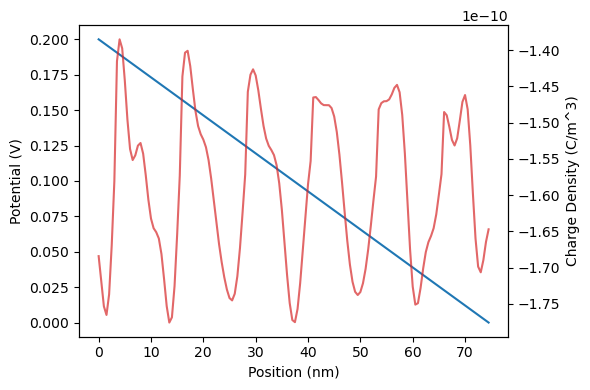

,iter,residual,update,omega_used
0,1,2.105757e-15,2.105757e-15,0.5


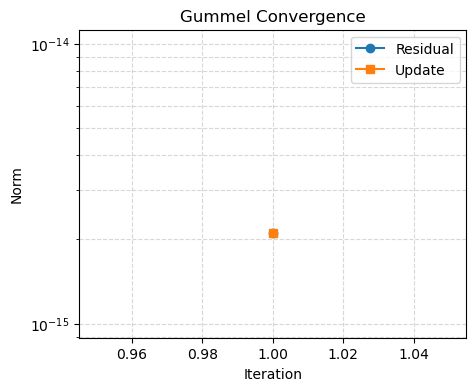

In [11]:
# Minimal coupled NEGF-Poisson solve
from poisson_gummel import run_coupled_negf_poisson

# Parameters
Ec_scalar = -2.0  
Efn_guess = np.zeros(ham.get_num_sites())  

# Absolute permittivity (silicon approx): 11.7 * eps0
EPS0 = 8.854e-12
epsilon_abs = 11.7 * EPS0

V_sol, rho_C_per_m3, coupler = run_coupled_negf_poisson(
    gf,
    device_length=ham.one_d_dx * (ham.get_num_sites()-1),
    mesh_points=ham.get_num_sites()-1,
    eps_abs=epsilon_abs,
    Ec=Ec_scalar,
    Efn=Efn_guess,
    N_D=1e21*0,  # uniform donor density (#/m^3)
    initial_V_left=0.2,
    initial_V_right=0.0,
    site_volume_m3=ham.one_d_dx,  # assume 1 m^2 cross-section
    max_iters=40,
    tol=5e-5,
    omega=0.5,
    anderson_m=5,
    method='ozaki_cfr',
    derivative_method='ozaki_cfr',
    ozaki_cutoff=60,
)

print('Final potential shape:', V_sol.shape)
print('Charge density stats (C/m^3): min={:.3e} max={:.3e} mean={:.3e}'.format(rho_C_per_m3.min(), rho_C_per_m3.max(), rho_C_per_m3.mean()))

# Plot
import matplotlib.pyplot as plt
coords = coupler.V_space.tabulate_dof_coordinates()[:,0]
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(coords*1e9, V_sol, label='Potential')
ax1.set_xlabel('Position (nm)')
ax1.set_ylabel('Potential (V)')
ax2 = ax1.twinx()
ax2.plot(coords*1e9, rho_C_per_m3, color='tab:red', alpha=0.7, label='Charge Density')
ax2.set_ylabel('Charge Density (C/m^3)')
fig.tight_layout(); plt.show()

# Convergence diagnostics
if coupler.comm.rank == 0:
    import pandas as pd
    res = coupler.diag.residual_norms
    upd = coupler.diag.update_norms
    and_used = coupler.diag.anderson_used
    omegas = coupler.diag.mixing_factors
    lengths = [len(res), len(upd), len(omegas)]
    min_len = min(lengths)
    if len(set(lengths)) != 1:
        print(f"[Note] Trimming diagnostic arrays to common length {min_len} from lengths {lengths}")
        res = res[:min_len]
        upd = upd[:min_len]
        omegas = omegas[:min_len]
    df = pd.DataFrame({
        'iter': np.arange(1, min_len+1),
        'residual': res,
        'update': upd,
        'omega_used': omegas,
    })
    display(df)
    plt.figure(figsize=(5,4))
    plt.semilogy(df['iter'], df['residual'], 'o-', label='Residual')
    plt.semilogy(df['iter'], df['update'], 's-', label='Update')
    plt.xlabel('Iteration'); plt.ylabel('Norm'); plt.legend(); plt.title('Gummel Convergence'); plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.show()

In [13]:
gf.compute_total_current()

Starting current calculations for 300 (E, ky) pairs...


np.float64(1.554566337830421e-05)